In [17]:
# NATURAL LANGUAGE PROCESSOR


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, confusion_matrix
import missingno as mns 
import nltk
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re 
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [18]:
df = pd.read_csv('Tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


<Axes: >

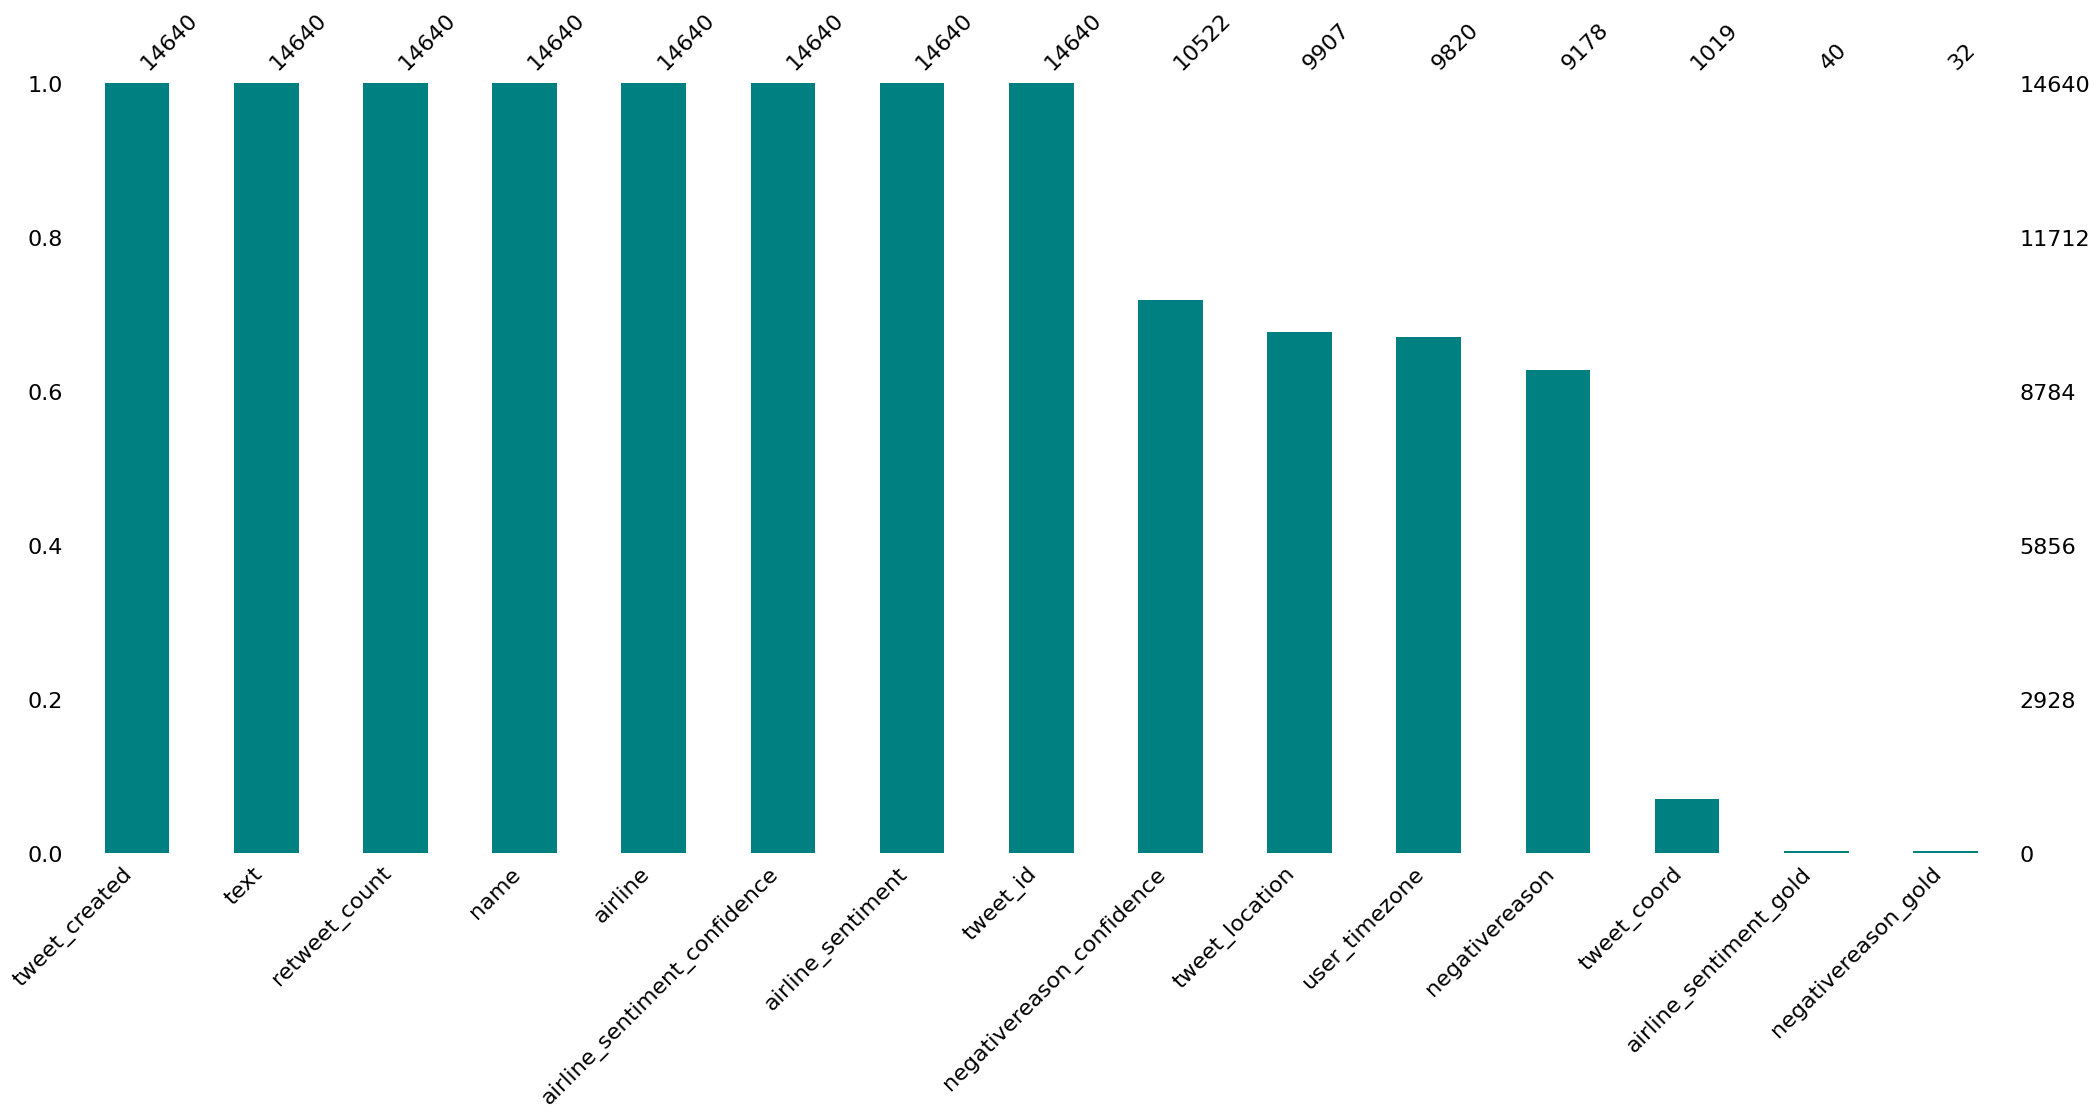

In [19]:
# when it comes to classification, we only consider two columns
# 1. text column and the 2. the outcome column
# other column are only useful for data analysis

# text column in the data above = Text
# the outcome column = airline_sentiment
# we check for the missing value using missingno
df['airline_sentiment'].isnull().sum()

mns.bar(df, color = 'teal', sort = 'descending')

In [20]:
fig = px.histogram(x = df['airline'], text_auto= True, color = df['negativereason'])
fig.show()

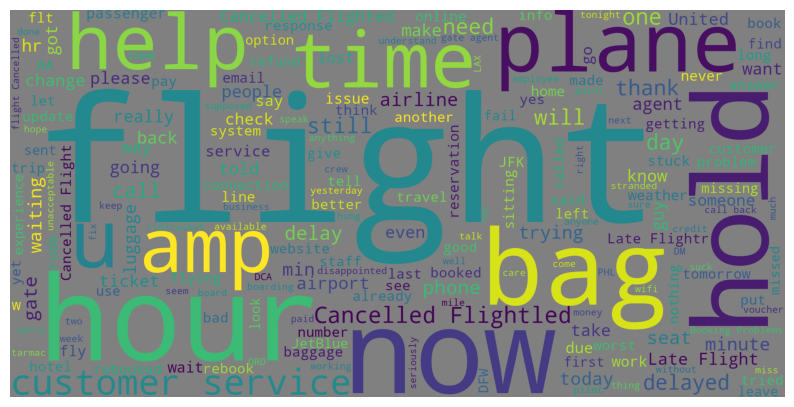

In [21]:
# from the histogram above it is clear that the major problem is the customer service. hence we recommend a comprehensive training
# note that if the text column has missing value, you will have to drop the missing values and not fill in order not to alter the given outcom
# to build a machin model, we need to build wordcloud. wordcloud is a colour representation of text

newdata = df[df['airline_sentiment'] == 'negative']
word = " ".join(newdata['text'])
# to clear words that are not in text form:
clw = " ".join([word for word in word.split() if 'http' not in word and not word.startswith('@') and word != 'RT'])
wc = WordCloud(stopwords = STOPWORDS, background_color= 'grey', width = 2000, height = 1000).generate(clw)
plt.figure(1, figsize=(10,10))
plt.imshow(wc)
plt.axis('off')
plt.show()

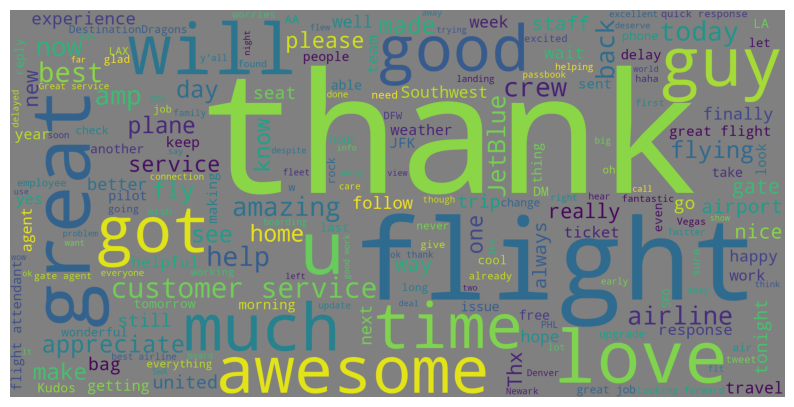

In [22]:
newdata = df[df['airline_sentiment'] == 'positive']
word = " ".join(newdata['text'])
# to clear words that are not in text form:
clw = " ".join([word for word in word.split() if 'http' not in word and not word.startswith('@') and word != 'RT'])
wc = WordCloud(stopwords = STOPWORDS, background_color= 'grey', width = 2000, height = 1000).generate(clw)
plt.figure(1, figsize=(10,10))
plt.imshow(wc)
plt.axis('off')
plt.show()

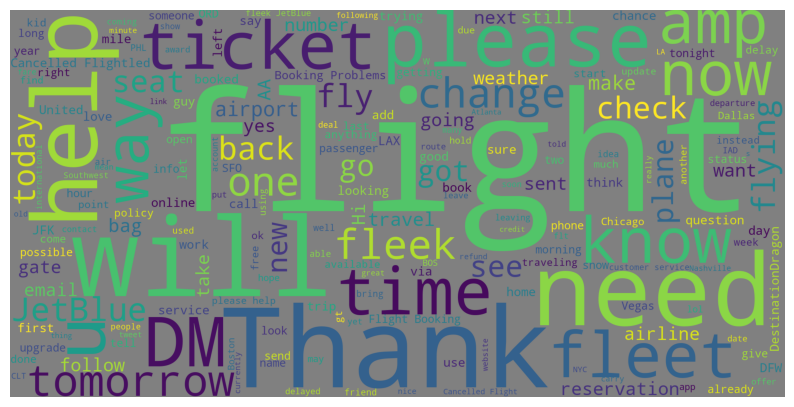

In [23]:
newdata = df[df['airline_sentiment'] == 'neutral']
word = " ".join(newdata['text'])
# to clear words that are not in text form:
clw = " ".join([word for word in word.split() if 'http' not in word and not word.startswith('@') and word != 'RT'])
wc = WordCloud(stopwords = STOPWORDS, background_color= 'grey', width = 2000, height = 1000).generate(clw)
plt.figure(1, figsize=(10,10))
plt.imshow(wc)
plt.axis('off')
plt.show()

In [24]:
from sklearn.utils import resample
df_neg = df[df['airline_sentiment'] == 'negative']
df_pos = df[df['airline_sentiment'] == 'positive']
df_neu = df[df['airline_sentiment'] == 'neutral']
df_neu_sam = resample(df_neu, n_samples = 9178)
df_pos_sam = resample(df_pos, n_samples = 9178)
df = pd.concat([df_neg, df_neu_sam, df_pos_sam], ignore_index= True)
df = df.sample(frac = 1)
df['airline_sentiment'].value_counts()

airline_sentiment
positive    9178
neutral     9178
negative    9178
Name: count, dtype: int64

In [25]:
# PROPER TEXT CLEANING FOR THE MACHINE LEARNING

text_cleaning_re = "@\S+|https?:\s|[^A-Za-z0-9]+"
def preprocess(x, stem = False):
    x = re.sub(text_cleaning_re, " ", str(x).lower()).strip()
    tokens = []
    for token in x.split():
        if token not in stop_words:
            if stem:
                tokens.append(SnowballStemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)
df['text'] = df['text'].apply(lambda x: preprocess(x))

In [26]:
# MACHINE LEARNING PROPER USING THE DATA
x = df.text
y = df['airline_sentiment']
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.2, random_state = 1)
from sklearn.pipeline import Pipeline
clf1 =  Pipeline([('vectorize', CountVectorizer()), ('transformer', TfidfTransformer()), ('model', MultinomialNB())])
clf2 =  Pipeline([('vectorize', CountVectorizer()), ('transformer', TfidfTransformer()), ('model', BernoulliNB())])
clf3 =  Pipeline([('vectorize', CountVectorizer()), ('transformer', TfidfTransformer()), ('model', MLPClassifier(hidden_layer_sizes=(10,10)))])

In [27]:
clf1.fit(xtrain,ytrain)

Pipeline(steps=[('vectorize', CountVectorizer()),
                ('transformer', TfidfTransformer()),
                ('model', MultinomialNB())])

In [28]:
# TO CHECK THE CLASSIFICATION REPORT
pred1 = clf1.predict(xtest)
print(classification_report(ytest,pred1))

              precision    recall  f1-score   support

    negative       0.79      0.85      0.82      1762
     neutral       0.85      0.77      0.81      1896
    positive       0.89      0.90      0.89      1849

    accuracy                           0.84      5507
   macro avg       0.84      0.84      0.84      5507
weighted avg       0.84      0.84      0.84      5507



In [29]:
# from the above analysis, the negative class is more than the positive and the neutral.
# assingment: try to correct these error.

clf2.fit(xtrain,ytrain)

Pipeline(steps=[('vectorize', CountVectorizer()),
                ('transformer', TfidfTransformer()), ('model', BernoulliNB())])

In [30]:
pred2 = clf2.predict(xtest)
print(classification_report(ytest,pred2))

              precision    recall  f1-score   support

    negative       0.84      0.80      0.82      1762
     neutral       0.83      0.79      0.81      1896
    positive       0.85      0.92      0.88      1849

    accuracy                           0.84      5507
   macro avg       0.84      0.84      0.84      5507
weighted avg       0.84      0.84      0.84      5507



In [31]:
clf3.fit(xtrain,ytrain)

Pipeline(steps=[('vectorize', CountVectorizer()),
                ('transformer', TfidfTransformer()),
                ('model', MLPClassifier(hidden_layer_sizes=(10, 10)))])

In [32]:
pred3 = clf3.predict(xtest)
print(classification_report(ytest,pred3))


# balance the accuracy to use gridsearch this is a machine learning function that toon each algorithm parameter to get the best outcome out of it

              precision    recall  f1-score   support

    negative       0.96      0.76      0.85      1762
     neutral       0.85      0.95      0.89      1896
    positive       0.92      0.99      0.95      1849

    accuracy                           0.90      5507
   macro avg       0.91      0.90      0.90      5507
weighted avg       0.91      0.90      0.90      5507



In [38]:
# using gridsearch:
from sklearn.model_selection import GridSearchCV
pram_grid1 = {
    'vectorize__max_df': [0.75, 1.0],
    'vectorize__min_df': [1,3],
    'transformer__use_idf':  [True, False],
    'model__alpha': [0.1, 1.0]
}

pram_grid2 = {
    'vectorize__max_df': [0.75, 1.0],
    'vectorize__min_df': [1,3],
    'transformer__use_idf':  [True, False],
    'model__alpha': [0.1, 1.0]
}

pram_grid3 = {
    'vectorize__max_df': [0.75, 1.0],
    'vectorize__min_df': [1,3],
    'transformer__use_idf':  [True, False],
    'model__hidden_layer_sizes': [(10,10), (20,20)],
    'model__activation': ['relu', 'identity', 'logistic', 'tanh'],
    'model__solver': ['lbfgs', 'sgd', 'adam']
}
pipelines = [clf1,clf2,clf3]
pram_grids = [pram_grid1,pram_grid2,pram_grid3]
best_estimators = []
for i, (pipelines,pram_grids) in enumerate(zip(pipelines,pram_grids)):
    grid_search = GridSearchCV(pipelines,pram_grids,cv = 5, scoring = 'accuracy', n_jobs=-1)
    grid_search.fit(xtrain,ytrain)
    print(f'Best parameter for clf{i+1}: {grid_search.best_params_}')
    print(f'Best ceoss validation score for clf{i+1}: {grid_search.best_score_}')
    best_estimators.append(grid_search.best_estimator_)

Best parameter for clf1: {'model__alpha': 0.1, 'transformer__use_idf': True, 'vectorize__max_df': 0.75, 'vectorize__min_df': 1}
Best ceoss validation score for clf1: 0.8516819546970054
Best parameter for clf2: {'model__alpha': 0.1, 'transformer__use_idf': True, 'vectorize__max_df': 0.75, 'vectorize__min_df': 1}
Best ceoss validation score for clf2: 0.8464157585131822
